# ★ 실무 실습) 배포 받은 "전력사용량 예측 데이터"를 통해 자신만의 코드를 작성 해보자

1. 이제까지 배운 회귀 방법들을 통해 적용해보자.
2. 하나의 포트폴리오가 될 수 있도록 시각화와 통계를 자유롭게 작성해보자.

 [시각화는 scatter plot, correlation plot. 통계는 describe 정도 출력해도 좋다.]

3. 모든 기법을 다 쓰는 것보다는 필요 할 것 같다는 코드만 작성해보기

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from tqdm import tqdm
import time
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import warnings

In [2]:
# 오류 무시
warnings.filterwarnings("ignore")

In [3]:
# 한글 폰트 깨짐 방지를 위함
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [4]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
train = pd.read_csv('/content/drive/MyDrive/오승환강사님/회귀과제/energy/train.csv', encoding = 'cp949')
test = pd.read_csv('/content/drive/MyDrive/오승환강사님/회귀과제/energy/test.csv', encoding = 'cp949')

In [6]:
train

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0
122396,60,2020-08-24 20,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0
122397,60,2020-08-24 21,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0
122398,60,2020-08-24 22,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0


In [7]:
test

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10076,60,2020-08-31 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10077,60,2020-08-31 21,27.9,4.1,68.0,NaN,0.0,1.0,1.0
10078,60,2020-08-31 22,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 기술통계량 확인

In [8]:
train.describe()

,num,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
count,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000
mean,30.500000,2324.830866,24.251713,2.151641,80.169848,0.514989,0.213533,0.683333,0.483333
std,17.318173,2058.999326,3.407902,1.514475,15.525862,2.624505,0.370517,0.465178,0.499724
min,1.000000,0.000000,11.100000,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000
25%,15.750000,1055.268000,21.800000,1.100000,70.000000,0.000000,0.000000,0.000000,0.000000
50%,30.500000,1700.352000,24.200000,1.900000,84.000000,0.000000,0.000000,1.000000,0.000000
75%,45.250000,2780.487000,26.500000,2.900000,93.000000,0.000000,0.300000,1.000000,1.000000
max,60.000000,17739.225000,36.300000,20.100000,100.000000,81.500000,1.000000,1.000000,1.000000


In [9]:
test.describe()

,num,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
count,10080.000000,3360.000000,3360.000000,3360.000000,1680.000000,3360.000000,2296.0,1624.0
mean,30.500000,27.805804,2.440327,81.963095,2.191845,0.612917,1.0,1.0
std,17.318961,2.378122,1.835905,11.900843,6.786772,0.929587,0.0,0.0
min,1.000000,22.100000,0.000000,44.000000,0.000000,0.000000,1.0,1.0
25%,15.750000,26.000000,1.100000,74.000000,0.000000,0.000000,1.0,1.0
50%,30.500000,27.500000,2.100000,83.000000,0.000000,0.000000,1.0,1.0
75%,45.250000,29.200000,3.200000,92.000000,0.900000,1.000000,1.0,1.0
max,60.000000,35.400000,22.500000,100.000000,83.500000,3.000000,1.0,1.0


# 결측치 확인

In [10]:
train.isnull().sum()

,0
num,0
date_time,0
전력사용량(kWh),0
기온(°C),0
풍속(m/s),0
습도(%),0
강수량(mm),0
일조(hr),0
비전기냉방설비운영,0
태양광보유,0


In [11]:
test.isnull().sum()

,0
num,0
date_time,0
기온(°C),6720
풍속(m/s),6720
습도(%),6720
"강수량(mm, 6시간)",8400
"일조(hr, 3시간)",6720
비전기냉방설비운영,7784
태양광보유,8456


# test 결측치 대체
- 기온, 풍속, 습도, 강수량, 일조 : 보간법
- 비전기냉방설비운영, 태양광보유 : 최빈값

In [12]:
# 1. 기온, 풍속, 습도, 강수량, 일조: 보간법(interpolation)
test['기온(°C)'] = test['기온(°C)'].interpolate(method='linear')
test['풍속(m/s)'] = test['풍속(m/s)'].interpolate(method='linear')
test['습도(%)'] = test['습도(%)'].interpolate(method='linear')
test['강수량(mm, 6시간)'] = test['강수량(mm, 6시간)'].interpolate(method='linear')
test['일조(hr, 3시간)'] = test['일조(hr, 3시간)'].interpolate(method='linear')

# 2. 비전기냉방설비운영, 태양광보유: 최빈값으로 채우기
test['비전기냉방설비운영'] = test['비전기냉방설비운영'].fillna(test['비전기냉방설비운영'].mode()[0])
test['태양광보유'] = test['태양광보유'].fillna(test['태양광보유'].mode()[0])

In [13]:
test.isnull().sum()

,0
num,0
date_time,0
기온(°C),0
풍속(m/s),0
습도(%),0
"강수량(mm, 6시간)",0
"일조(hr, 3시간)",0
비전기냉방설비운영,0
태양광보유,0


In [14]:
# train['date_time'] = pd.to_datetime(train['date_time'])
# test['date_time'] = pd.to_datetime(test['date_time'])

# 상관관계 확인

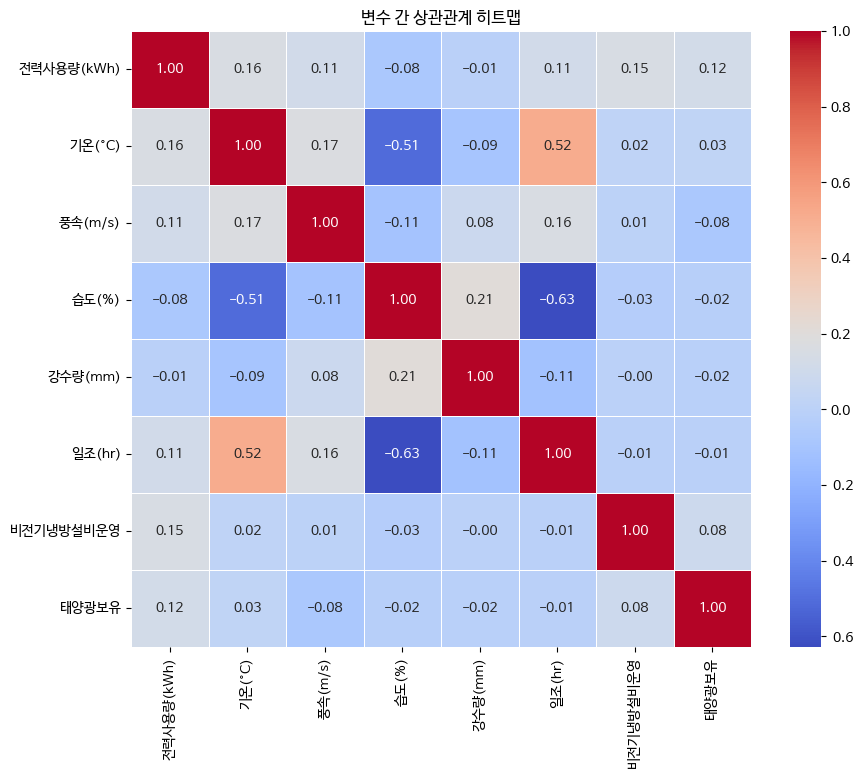

In [15]:
df_corr = train[['전력사용량(kWh)', '기온(°C)', '풍속(m/s)', '습도(%)', '강수량(mm)', '일조(hr)', '비전기냉방설비운영', '태양광보유']]

# 상관계수 행렬 계산
corr_matrix = df_corr.corr()

# 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('변수 간 상관관계 히트맵')
plt.show()

## 기온과 전력사용량 확인

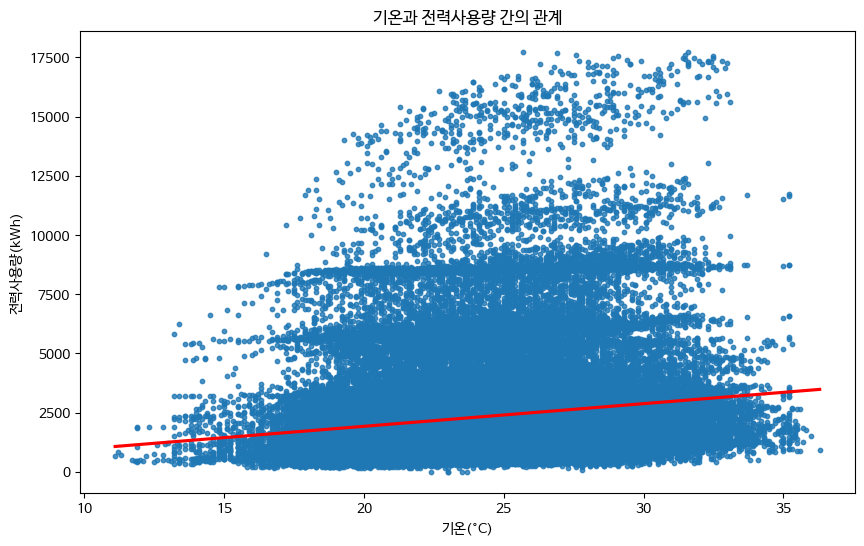

In [22]:
plt.figure(figsize=(10, 6))
sns.regplot(x='기온(°C)', y='전력사용량(kWh)', data = train, scatter_kws={'s':10}, line_kws={'color':'red'})
plt.title('기온과 전력사용량 간의 관계')
plt.xlabel('기온(°C)')
plt.ylabel('전력사용량(kWh)')
plt.show()

# 비전기냉방설비보유와 전력사용량 확인

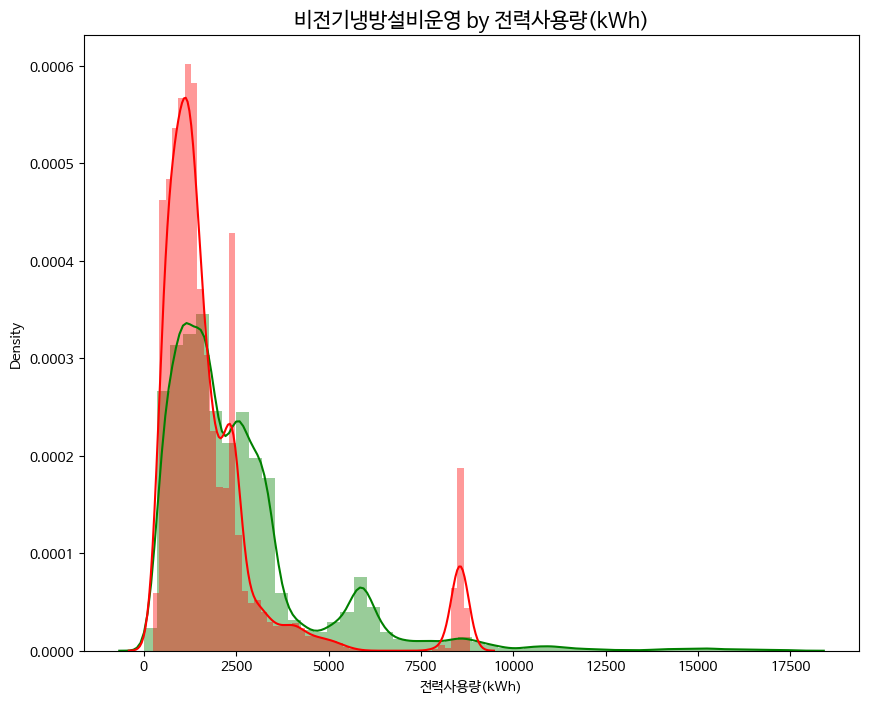

In [25]:
plt.figure(figsize=(10,8))

sns.distplot(train[train['비전기냉방설비운영'] == 1]["전력사용량(kWh)"], color='green')
sns.distplot(train[train['비전기냉방설비운영'] == 0]["전력사용량(kWh)"], color='red')

plt.title('비전기냉방설비운영 by 전력사용량(kWh)', fontsize=15)
plt.show()

# 최적 클러스터 찾기

In [30]:
features = train[['전력사용량(kWh)', '기온(°C)', '풍속(m/s)', '습도(%)', '강수량(mm)', '일조(hr)', '비전기냉방설비운영', '태양광보유']]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

## 엘보우 포인트

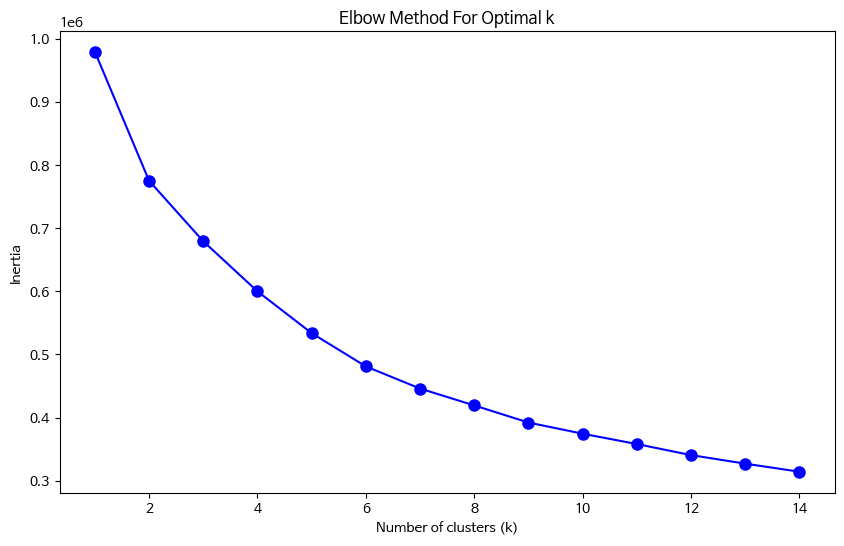

In [31]:
inertia = []
K = range(1, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Graph
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bo-', markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

## 실루엣지수
- 돌아가는데 너무 오래걸림

In [33]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
K = range(2, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    score = silhouette_score(scaled_features, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, 'bo-', markersize=8)
plt.xlabel('클러스터 수 (k)')
plt.ylabel('실루엣 지수')
plt.title('최적의 k를 찾기 위한 실루엣 지수')
plt.show()


KeyboardInterrupt: 

# 날짜 데이터 분리

In [37]:
train['date_time'] = pd.to_datetime(train['date_time'])

# 연도, 월, 일, 시간 열 추가
train['연도'] = train['date_time'].dt.year
train['월'] = train['date_time'].dt.month
train['일'] = train['date_time'].dt.day
train['시간'] = train['date_time'].dt.hour

In [38]:
test['date_time'] = pd.to_datetime(test['date_time'])

# 연도, 월, 일, 시간 열 추가
test['연도'] = test['date_time'].dt.year
test['월'] = test['date_time'].dt.month
test['일'] = test['date_time'].dt.day
test['시간'] = test['date_time'].dt.hour

In [40]:
del train['date_time']
del test['date_time']

# 모델링

In [42]:
X = train.drop(columns=['전력사용량(kWh)']).values  # 'alcohol' 열을 제외한 나머지 특성 사용
y = train['전력사용량(kWh)'].values  # 와인의 알콜을 종속 변수로 선택

# KMeans 클러스터링을 통해 파생변수 생성
kmeans = KMeans(n_clusters = 2, random_state = 42)
cluster_labels = kmeans.fit_predict(X)

# 원래 데이터에 클러스터 라벨 추가
X_extended = pd.concat([pd.DataFrame(X), pd.DataFrame(cluster_labels, columns=['cluster'])], axis=1).values

# 데이터 정규화
scaler = StandardScaler()
X_extended[:, :-1] = scaler.fit_transform(X_extended[:, :-1])  # 클러스터 레이블 제외하고 정규화

# 데이터를 텐서로 변환
X_tensor = torch.tensor(X_extended, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

class DNNRegression(nn.Module):
    def __init__(self):
        super(DNNRegression, self).__init__()
        self.layer1 = nn.Linear(X_tensor.shape[1], 128) # X_tensor로 변환!!!!
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.5)

        self.layer2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.5)

        self.layer3 = nn.Linear(256, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.dropout3 = nn.Dropout(0.5)

        self.layer4 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(0.5)

        self.layer5 = nn.Linear(128, 64)
        self.bn5 = nn.BatchNorm1d(64)
        self.dropout5 = nn.Dropout(0.5)

        self.output_layer = nn.Linear(64, 1)

        # 가중치 초기화
        self._initialize_weights()

    def forward(self, x):
        x = torch.relu(self.bn1(self.layer1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.layer2(x)))
        x = self.dropout2(x)
        x = torch.relu(self.bn3(self.layer3(x)))
        x = self.dropout3(x)
        x = torch.relu(self.bn4(self.layer4(x)))
        x = self.dropout4(x)
        x = torch.relu(self.bn5(self.layer5(x)))
        x = self.dropout5(x)
        x = self.output_layer(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

# Hyperparameters
learning_rate = 0.001
weight_decay = 0.1
num_epochs = 10
batch_size = 64

# K-Fold Cross Validation
kf = KFold(n_splits=5,  shuffle=True, random_state=42)
fold = 1

# Early Stopping 설정
early_stopping_patience = 5
best_loss = float('inf')

# 로그 파일 설정
log_file = "training_log.txt"
if os.path.exists(log_file):
    os.remove(log_file)

# 학습 및 평가
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

valid_losses = []

for train_index, val_index in kf.split(X_tensor):
    X_train_fold, X_valid_fold = X_tensor[train_index], X_tensor[val_index]
    y_train_fold, y_valid_fold = y_tensor[train_index], y_tensor[val_index]

    train_dataset = TensorDataset(X_train_fold, y_train_fold)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = DNNRegression().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.1)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 2, gamma = 0.1)

    # 학습 시간 측정 시작
    start_time = time.time()

    early_stopping_counter = 0
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # 데이터를 GPU로 이동

            # 예측값 계산
            predictions = model(batch_X)

            # 손실 계산
            loss = criterion(predictions, batch_y)

            # 옵티마이저 초기화
            optimizer.zero_grad()

            # 역전파 및 가중치 갱신
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # 학습률 업데이트
        scheduler.step()

        # 평가 손실 계산
        model.eval()
        with torch.no_grad():
            X_valid_fold, y_valid_fold = X_valid_fold.to(device), y_valid_fold.to(device)
            val_predictions = model(X_valid_fold)
            val_loss = criterion(val_predictions, y_valid_fold)

        # log 파일에 정보 기록
        with open(log_file, "a") as f:
            f.write(f"Fold {fold}, Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}, Valid Loss: {val_loss.item():.4f}\n")

        # tqdm 진행 표시줄 업데이트
        tqdm.write(f"Fold {fold}, Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}, Valid Loss: {val_loss.item():.4f}")

        # Early Stopping
        if val_loss.item() < best_loss:
            best_loss = val_loss.item()
            early_stopping_counter = 0
            # 성능이 뛰어날때 마다 모델을 저장
            torch.save(model.state_dict(), "best_model.pth")

        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print(f"조기종료 epoch: {epoch+1}")
                break

    # 모델 불러오기 및 평가
    model.load_state_dict(torch.load("best_model.pth"))
    model.eval()
    with torch.no_grad():
        predictions = model(X_valid_fold)
        final_loss = criterion(predictions, y_valid_fold)
        print(f'Final 평가 손실 Loss: {final_loss.item():.4f}')
        print(f"예측 값: {predictions[:5].view(-1).tolist()}")
        print(f"실제 값: {y_valid_fold[:5].view(-1).tolist()}\n")
        valid_losses.append(final_loss.item())

    fold += 1

# Kfold의 loss 모음
print('\nK-Fold Loss List')
print(np.mean(valid_losses))

Fold 1, Epoch 1/10, Loss: 8946186.3101, Valid Loss: 7534624.5000
Fold 1, Epoch 2/10, Loss: 6176302.4570, Valid Loss: 4626808.5000
Fold 1, Epoch 3/10, Loss: 4706316.4748, Valid Loss: 4289622.5000
Fold 1, Epoch 4/10, Loss: 4490244.2431, Valid Loss: 3953425.2500
Fold 1, Epoch 5/10, Loss: 4370154.9412, Valid Loss: 3896633.2500
Fold 1, Epoch 6/10, Loss: 4328911.4552, Valid Loss: 4000871.2500
Fold 1, Epoch 7/10, Loss: 4323243.1808, Valid Loss: 4053079.7500
Fold 1, Epoch 8/10, Loss: 4330414.6784, Valid Loss: 4063347.5000
Fold 1, Epoch 9/10, Loss: 4325061.9904, Valid Loss: 3819982.5000
Fold 1, Epoch 10/10, Loss: 4342054.3645, Valid Loss: 3944629.7500
Final 평가 손실 Loss: 3819982.5000
예측 값: [4115.494140625, 4315.28857421875, 4193.2431640625, 4937.5400390625, 5212.1630859375]
실제 값: [8179.05615234375, 8048.80810546875, 7945.1279296875, 7836.912109375, 7989.83984375]

Fold 2, Epoch 1/10, Loss: 8972691.8474, Valid Loss: 7726974.5000
Fold 2, Epoch 2/10, Loss: 6205354.9822, Valid Loss: 4484923.0000
Fold

## 드롭아웃 바꾸기 -> 0.1

In [43]:
X = train.drop(columns=['전력사용량(kWh)']).values  # 'alcohol' 열을 제외한 나머지 특성 사용
y = train['전력사용량(kWh)'].values  # 와인의 알콜을 종속 변수로 선택

# KMeans 클러스터링을 통해 파생변수 생성
kmeans = KMeans(n_clusters = 2, random_state = 42)
cluster_labels = kmeans.fit_predict(X)

# 원래 데이터에 클러스터 라벨 추가
X_extended = pd.concat([pd.DataFrame(X), pd.DataFrame(cluster_labels, columns=['cluster'])], axis=1).values

# 데이터 정규화
scaler = StandardScaler()
X_extended[:, :-1] = scaler.fit_transform(X_extended[:, :-1])  # 클러스터 레이블 제외하고 정규화

# 데이터를 텐서로 변환
X_tensor = torch.tensor(X_extended, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

class DNNRegression(nn.Module):
    def __init__(self):
        super(DNNRegression, self).__init__()
        self.layer1 = nn.Linear(X_tensor.shape[1], 128) # X_tensor로 변환!!!!
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.1)

        self.layer2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.1)

        self.layer3 = nn.Linear(256, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.dropout3 = nn.Dropout(0.1)

        self.layer4 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(0.1)

        self.layer5 = nn.Linear(128, 64)
        self.bn5 = nn.BatchNorm1d(64)
        self.dropout5 = nn.Dropout(0.1)

        self.output_layer = nn.Linear(64, 1)

        # 가중치 초기화
        self._initialize_weights()

    def forward(self, x):
        x = torch.relu(self.bn1(self.layer1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.layer2(x)))
        x = self.dropout2(x)
        x = torch.relu(self.bn3(self.layer3(x)))
        x = self.dropout3(x)
        x = torch.relu(self.bn4(self.layer4(x)))
        x = self.dropout4(x)
        x = torch.relu(self.bn5(self.layer5(x)))
        x = self.dropout5(x)
        x = self.output_layer(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

# Hyperparameters
learning_rate = 0.001
weight_decay = 0.1
num_epochs = 10
batch_size = 64

# K-Fold Cross Validation
kf = KFold(n_splits=5,  shuffle=True, random_state=42)
fold = 1

# Early Stopping 설정
early_stopping_patience = 5
best_loss = float('inf')

# 로그 파일 설정
log_file = "training_log.txt"
if os.path.exists(log_file):
    os.remove(log_file)

# 학습 및 평가
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

valid_losses = []

for train_index, val_index in kf.split(X_tensor):
    X_train_fold, X_valid_fold = X_tensor[train_index], X_tensor[val_index]
    y_train_fold, y_valid_fold = y_tensor[train_index], y_tensor[val_index]

    train_dataset = TensorDataset(X_train_fold, y_train_fold)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = DNNRegression().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.1)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 2, gamma = 0.1)

    # 학습 시간 측정 시작
    start_time = time.time()

    early_stopping_counter = 0
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # 데이터를 GPU로 이동

            # 예측값 계산
            predictions = model(batch_X)

            # 손실 계산
            loss = criterion(predictions, batch_y)

            # 옵티마이저 초기화
            optimizer.zero_grad()

            # 역전파 및 가중치 갱신
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # 학습률 업데이트
        scheduler.step()

        # 평가 손실 계산
        model.eval()
        with torch.no_grad():
            X_valid_fold, y_valid_fold = X_valid_fold.to(device), y_valid_fold.to(device)
            val_predictions = model(X_valid_fold)
            val_loss = criterion(val_predictions, y_valid_fold)

        # log 파일에 정보 기록
        with open(log_file, "a") as f:
            f.write(f"Fold {fold}, Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}, Valid Loss: {val_loss.item():.4f}\n")

        # tqdm 진행 표시줄 업데이트
        tqdm.write(f"Fold {fold}, Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}, Valid Loss: {val_loss.item():.4f}")

        # Early Stopping
        if val_loss.item() < best_loss:
            best_loss = val_loss.item()
            early_stopping_counter = 0
            # 성능이 뛰어날때 마다 모델을 저장
            torch.save(model.state_dict(), "best_model.pth")

        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print(f"조기종료 epoch: {epoch+1}")
                break

    # 모델 불러오기 및 평가
    model.load_state_dict(torch.load("best_model.pth"))
    model.eval()
    with torch.no_grad():
        predictions = model(X_valid_fold)
        final_loss = criterion(predictions, y_valid_fold)
        print(f'Final 평가 손실 Loss: {final_loss.item():.4f}')
        print(f"예측 값: {predictions[:5].view(-1).tolist()}")
        print(f"실제 값: {y_valid_fold[:5].view(-1).tolist()}\n")
        valid_losses.append(final_loss.item())

    fold += 1

# Kfold의 loss 모음
print('\nK-Fold Loss List')
print(np.mean(valid_losses))

Fold 1, Epoch 1/10, Loss: 8875717.5789, Valid Loss: 7558148.0000
Fold 1, Epoch 2/10, Loss: 5550815.9042, Valid Loss: 3298344.5000
Fold 1, Epoch 3/10, Loss: 3564603.7955, Valid Loss: 2797761.0000
Fold 1, Epoch 4/10, Loss: 3289273.4810, Valid Loss: 2609236.2500
Fold 1, Epoch 5/10, Loss: 3095823.5342, Valid Loss: 2554244.0000
Fold 1, Epoch 6/10, Loss: 3084090.8429, Valid Loss: 2562306.5000
Fold 1, Epoch 7/10, Loss: 3075921.2118, Valid Loss: 2518450.2500
Fold 1, Epoch 8/10, Loss: 3079378.4543, Valid Loss: 2418494.0000
Fold 1, Epoch 9/10, Loss: 3068398.2993, Valid Loss: 2470420.7500
Fold 1, Epoch 10/10, Loss: 3080803.8424, Valid Loss: 2504605.0000
Final 평가 손실 Loss: 2418494.0000
예측 값: [5460.56982421875, 5623.203125, 5576.7392578125, 5648.36474609375, 5738.2236328125]
실제 값: [8179.05615234375, 8048.80810546875, 7945.1279296875, 7836.912109375, 7989.83984375]

Fold 2, Epoch 1/10, Loss: 8847149.7570, Valid Loss: 7447464.5000
Fold 2, Epoch 2/10, Loss: 5517353.8790, Valid Loss: 3306792.0000
Fold 2

## 러닝레이트 변경 -> 0.0005

In [44]:
X = train.drop(columns=['전력사용량(kWh)']).values  # 'alcohol' 열을 제외한 나머지 특성 사용
y = train['전력사용량(kWh)'].values  # 와인의 알콜을 종속 변수로 선택

# KMeans 클러스터링을 통해 파생변수 생성
kmeans = KMeans(n_clusters = 2, random_state = 42)
cluster_labels = kmeans.fit_predict(X)

# 원래 데이터에 클러스터 라벨 추가
X_extended = pd.concat([pd.DataFrame(X), pd.DataFrame(cluster_labels, columns=['cluster'])], axis=1).values

# 데이터 정규화
scaler = StandardScaler()
X_extended[:, :-1] = scaler.fit_transform(X_extended[:, :-1])  # 클러스터 레이블 제외하고 정규화

# 데이터를 텐서로 변환
X_tensor = torch.tensor(X_extended, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

class DNNRegression(nn.Module):
    def __init__(self):
        super(DNNRegression, self).__init__()
        self.layer1 = nn.Linear(X_tensor.shape[1], 128) # X_tensor로 변환!!!!
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.1)

        self.layer2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.1)

        self.layer3 = nn.Linear(256, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.dropout3 = nn.Dropout(0.1)

        self.layer4 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(0.1)

        self.layer5 = nn.Linear(128, 64)
        self.bn5 = nn.BatchNorm1d(64)
        self.dropout5 = nn.Dropout(0.1)

        self.output_layer = nn.Linear(64, 1)

        # 가중치 초기화
        self._initialize_weights()

    def forward(self, x):
        x = torch.relu(self.bn1(self.layer1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.layer2(x)))
        x = self.dropout2(x)
        x = torch.relu(self.bn3(self.layer3(x)))
        x = self.dropout3(x)
        x = torch.relu(self.bn4(self.layer4(x)))
        x = self.dropout4(x)
        x = torch.relu(self.bn5(self.layer5(x)))
        x = self.dropout5(x)
        x = self.output_layer(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

# Hyperparameters
learning_rate = 0.0005
weight_decay = 0.1
num_epochs = 10
batch_size = 64

# K-Fold Cross Validation
kf = KFold(n_splits=5,  shuffle=True, random_state=42)
fold = 1

# Early Stopping 설정
early_stopping_patience = 5
best_loss = float('inf')

# 로그 파일 설정
log_file = "training_log.txt"
if os.path.exists(log_file):
    os.remove(log_file)

# 학습 및 평가
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

valid_losses = []

for train_index, val_index in kf.split(X_tensor):
    X_train_fold, X_valid_fold = X_tensor[train_index], X_tensor[val_index]
    y_train_fold, y_valid_fold = y_tensor[train_index], y_tensor[val_index]

    train_dataset = TensorDataset(X_train_fold, y_train_fold)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = DNNRegression().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.1)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 2, gamma = 0.1)

    # 학습 시간 측정 시작
    start_time = time.time()

    early_stopping_counter = 0
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # 데이터를 GPU로 이동

            # 예측값 계산
            predictions = model(batch_X)

            # 손실 계산
            loss = criterion(predictions, batch_y)

            # 옵티마이저 초기화
            optimizer.zero_grad()

            # 역전파 및 가중치 갱신
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # 학습률 업데이트
        scheduler.step()

        # 평가 손실 계산
        model.eval()
        with torch.no_grad():
            X_valid_fold, y_valid_fold = X_valid_fold.to(device), y_valid_fold.to(device)
            val_predictions = model(X_valid_fold)
            val_loss = criterion(val_predictions, y_valid_fold)

        # log 파일에 정보 기록
        with open(log_file, "a") as f:
            f.write(f"Fold {fold}, Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}, Valid Loss: {val_loss.item():.4f}\n")

        # tqdm 진행 표시줄 업데이트
        tqdm.write(f"Fold {fold}, Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}, Valid Loss: {val_loss.item():.4f}")

        # Early Stopping
        if val_loss.item() < best_loss:
            best_loss = val_loss.item()
            early_stopping_counter = 0
            # 성능이 뛰어날때 마다 모델을 저장
            torch.save(model.state_dict(), "best_model.pth")

        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print(f"조기종료 epoch: {epoch+1}")
                break

    # 모델 불러오기 및 평가
    model.load_state_dict(torch.load("best_model.pth"))
    model.eval()
    with torch.no_grad():
        predictions = model(X_valid_fold)
        final_loss = criterion(predictions, y_valid_fold)
        print(f'Final 평가 손실 Loss: {final_loss.item():.4f}')
        print(f"예측 값: {predictions[:5].view(-1).tolist()}")
        print(f"실제 값: {y_valid_fold[:5].view(-1).tolist()}\n")
        valid_losses.append(final_loss.item())

    fold += 1

# Kfold의 loss 모음
print('\nK-Fold Loss List')
print(np.mean(valid_losses))

Fold 1, Epoch 1/10, Loss: 8836827.0493, Valid Loss: 7313595.5000
Fold 1, Epoch 2/10, Loss: 5497254.5244, Valid Loss: 3237082.2500
Fold 1, Epoch 3/10, Loss: 3490530.7598, Valid Loss: 2713694.0000
Fold 1, Epoch 4/10, Loss: 3191220.3895, Valid Loss: 2378752.0000
Fold 1, Epoch 5/10, Loss: 3044698.1227, Valid Loss: 2409330.2500
Fold 1, Epoch 6/10, Loss: 3013367.1518, Valid Loss: 2509361.0000
Fold 1, Epoch 7/10, Loss: 3000385.2552, Valid Loss: 2378749.5000
Fold 1, Epoch 8/10, Loss: 3007259.8305, Valid Loss: 2356322.7500
Fold 1, Epoch 9/10, Loss: 3008493.6082, Valid Loss: 2395314.7500
Fold 1, Epoch 10/10, Loss: 3003938.5319, Valid Loss: 2368004.2500
Final 평가 손실 Loss: 2356322.7500
예측 값: [5605.38916015625, 5699.88623046875, 5637.20458984375, 5647.80322265625, 5667.3857421875]
실제 값: [8179.05615234375, 8048.80810546875, 7945.1279296875, 7836.912109375, 7989.83984375]

Fold 2, Epoch 1/10, Loss: 8827510.7038, Valid Loss: 7259442.5000
Fold 2, Epoch 2/10, Loss: 5415617.5543, Valid Loss: 3138662.7500


## 드랍아웃 -> 0.01

In [45]:
X = train.drop(columns=['전력사용량(kWh)']).values  # 'alcohol' 열을 제외한 나머지 특성 사용
y = train['전력사용량(kWh)'].values  # 와인의 알콜을 종속 변수로 선택

# KMeans 클러스터링을 통해 파생변수 생성
kmeans = KMeans(n_clusters = 2, random_state = 42)
cluster_labels = kmeans.fit_predict(X)

# 원래 데이터에 클러스터 라벨 추가
X_extended = pd.concat([pd.DataFrame(X), pd.DataFrame(cluster_labels, columns=['cluster'])], axis=1).values

# 데이터 정규화
scaler = StandardScaler()
X_extended[:, :-1] = scaler.fit_transform(X_extended[:, :-1])  # 클러스터 레이블 제외하고 정규화

# 데이터를 텐서로 변환
X_tensor = torch.tensor(X_extended, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

class DNNRegression(nn.Module):
    def __init__(self):
        super(DNNRegression, self).__init__()
        self.layer1 = nn.Linear(X_tensor.shape[1], 128) # X_tensor로 변환!!!!
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.01)

        self.layer2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.01)

        self.layer3 = nn.Linear(256, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.dropout3 = nn.Dropout(0.01)

        self.layer4 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(0.01)

        self.layer5 = nn.Linear(128, 64)
        self.bn5 = nn.BatchNorm1d(64)
        self.dropout5 = nn.Dropout(0.01)

        self.output_layer = nn.Linear(64, 1)

        # 가중치 초기화
        self._initialize_weights()

    def forward(self, x):
        x = torch.relu(self.bn1(self.layer1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.layer2(x)))
        x = self.dropout2(x)
        x = torch.relu(self.bn3(self.layer3(x)))
        x = self.dropout3(x)
        x = torch.relu(self.bn4(self.layer4(x)))
        x = self.dropout4(x)
        x = torch.relu(self.bn5(self.layer5(x)))
        x = self.dropout5(x)
        x = self.output_layer(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

# Hyperparameters
learning_rate = 0.001
weight_decay = 0.1
num_epochs = 10
batch_size = 64

# K-Fold Cross Validation
kf = KFold(n_splits=5,  shuffle=True, random_state=42)
fold = 1

# Early Stopping 설정
early_stopping_patience = 5
best_loss = float('inf')

# 로그 파일 설정
log_file = "training_log.txt"
if os.path.exists(log_file):
    os.remove(log_file)

# 학습 및 평가
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

valid_losses = []

for train_index, val_index in kf.split(X_tensor):
    X_train_fold, X_valid_fold = X_tensor[train_index], X_tensor[val_index]
    y_train_fold, y_valid_fold = y_tensor[train_index], y_tensor[val_index]

    train_dataset = TensorDataset(X_train_fold, y_train_fold)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = DNNRegression().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.1)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 2, gamma = 0.1)

    # 학습 시간 측정 시작
    start_time = time.time()

    early_stopping_counter = 0
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # 데이터를 GPU로 이동

            # 예측값 계산
            predictions = model(batch_X)

            # 손실 계산
            loss = criterion(predictions, batch_y)

            # 옵티마이저 초기화
            optimizer.zero_grad()

            # 역전파 및 가중치 갱신
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # 학습률 업데이트
        scheduler.step()

        # 평가 손실 계산
        model.eval()
        with torch.no_grad():
            X_valid_fold, y_valid_fold = X_valid_fold.to(device), y_valid_fold.to(device)
            val_predictions = model(X_valid_fold)
            val_loss = criterion(val_predictions, y_valid_fold)

        # log 파일에 정보 기록
        with open(log_file, "a") as f:
            f.write(f"Fold {fold}, Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}, Valid Loss: {val_loss.item():.4f}\n")

        # tqdm 진행 표시줄 업데이트
        tqdm.write(f"Fold {fold}, Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}, Valid Loss: {val_loss.item():.4f}")

        # Early Stopping
        if val_loss.item() < best_loss:
            best_loss = val_loss.item()
            early_stopping_counter = 0
            # 성능이 뛰어날때 마다 모델을 저장
            torch.save(model.state_dict(), "best_model.pth")

        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print(f"조기종료 epoch: {epoch+1}")
                break

    # 모델 불러오기 및 평가
    model.load_state_dict(torch.load("best_model.pth"))
    model.eval()
    with torch.no_grad():
        predictions = model(X_valid_fold)
        final_loss = criterion(predictions, y_valid_fold)
        print(f'Final 평가 손실 Loss: {final_loss.item():.4f}')
        print(f"예측 값: {predictions[:5].view(-1).tolist()}")
        print(f"실제 값: {y_valid_fold[:5].view(-1).tolist()}\n")
        valid_losses.append(final_loss.item())

    fold += 1

# Kfold의 loss 모음
print('\nK-Fold Loss List')
print(np.mean(valid_losses))

Fold 1, Epoch 1/10, Loss: 8878703.4761, Valid Loss: 7337493.0000
Fold 1, Epoch 2/10, Loss: 5398524.5760, Valid Loss: 2978494.5000
Fold 1, Epoch 3/10, Loss: 3324394.8180, Valid Loss: 2695509.7500
Fold 1, Epoch 4/10, Loss: 3013308.1092, Valid Loss: 2518374.0000
Fold 1, Epoch 5/10, Loss: 2843389.5056, Valid Loss: 2632237.2500
Fold 1, Epoch 6/10, Loss: 2809597.0897, Valid Loss: 2483608.7500
Fold 1, Epoch 7/10, Loss: 2784775.9817, Valid Loss: 2250616.2500
Fold 1, Epoch 8/10, Loss: 2790914.3986, Valid Loss: 2238487.5000
Fold 1, Epoch 9/10, Loss: 2792960.5648, Valid Loss: 2446837.7500
Fold 1, Epoch 10/10, Loss: 2805347.9335, Valid Loss: 2299515.5000
Final 평가 손실 Loss: 2238487.5000
예측 값: [5517.83349609375, 5604.2109375, 5463.48876953125, 5573.34228515625, 5591.4306640625]
실제 값: [8179.05615234375, 8048.80810546875, 7945.1279296875, 7836.912109375, 7989.83984375]

Fold 2, Epoch 1/10, Loss: 8817850.0484, Valid Loss: 7422960.0000
Fold 2, Epoch 2/10, Loss: 5244155.6455, Valid Loss: 3156407.7500
Fold

## 드랍아웃 규제 제거

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import os
import time
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from tqdm import tqdm

# 데이터 준비
X = train.drop(columns=['전력사용량(kWh)']).values
y = train['전력사용량(kWh)'].values

# KMeans 클러스터링
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X)

# 클러스터 라벨 추가 및 정규화
X_extended = pd.concat([pd.DataFrame(X), pd.DataFrame(cluster_labels, columns=['cluster'])], axis=1).values
scaler = StandardScaler()
X_extended[:, :-1] = scaler.fit_transform(X_extended[:, :-1])
X_tensor = torch.tensor(X_extended, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# 모델 정의
class DNNRegression(nn.Module):
    def __init__(self):
        super(DNNRegression, self).__init__()
        self.layer1 = nn.Linear(X_tensor.shape[1], 128)
        self.bn1 = nn.BatchNorm1d(128)

        self.layer2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)

        self.layer3 = nn.Linear(256, 256)
        self.bn3 = nn.BatchNorm1d(256)

        self.layer4 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)

        self.layer5 = nn.Linear(128, 64)
        self.bn5 = nn.BatchNorm1d(64)

        self.output_layer = nn.Linear(64, 1)

        # 가중치 초기화
        self._initialize_weights()

    def forward(self, x):
        x = torch.relu(self.bn1(self.layer1(x)))
        x = torch.relu(self.bn2(self.layer2(x)))
        x = torch.relu(self.bn3(self.layer3(x)))
        x = torch.relu(self.bn4(self.layer4(x)))
        x = torch.relu(self.bn5(self.layer5(x)))
        x = self.output_layer(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

# 하이퍼파라미터 설정
learning_rate = 0.001
num_epochs = 10
batch_size = 64

# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1

# Early Stopping 설정
early_stopping_patience = 5
best_loss = float('inf')

# 로그 파일 설정
log_file = "training_log.txt"
if os.path.exists(log_file):
    os.remove(log_file)

# 학습 및 평가
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
valid_losses = []

for train_index, val_index in kf.split(X_tensor):
    X_train_fold, X_valid_fold = X_tensor[train_index], X_tensor[val_index]
    y_train_fold, y_valid_fold = y_tensor[train_index], y_tensor[val_index]

    train_dataset = TensorDataset(X_train_fold, y_train_fold)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = DNNRegression().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

    # 학습 시간 측정 시작
    start_time = time.time()

    early_stopping_counter = 0
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # 데이터를 GPU로 이동

            # 예측값 계산
            predictions = model(batch_X)

            # 손실 계산
            loss = criterion(predictions, batch_y)

            # 옵티마이저 초기화
            optimizer.zero_grad()

            # 역전파 및 가중치 갱신
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # 학습률 업데이트
        scheduler.step()

        # 평가 손실 계산
        model.eval()
        with torch.no_grad():
            X_valid_fold, y_valid_fold = X_valid_fold.to(device), y_valid_fold.to(device)
            val_predictions = model(X_valid_fold)
            val_loss = criterion(val_predictions, y_valid_fold)

        # log 파일에 정보 기록
        with open(log_file, "a") as f:
            f.write(f"Fold {fold}, Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}, Valid Loss: {val_loss.item():.4f}\n")

        # tqdm 진행 표시줄 업데이트
        tqdm.write(f"Fold {fold}, Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}, Valid Loss: {val_loss.item():.4f}")

        # Early Stopping
        if val_loss.item() < best_loss:
            best_loss = val_loss.item()
            early_stopping_counter = 0
            # 성능이 뛰어날때 마다 모델을 저장
            torch.save(model.state_dict(), "best_model.pth")

        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print(f"조기종료 epoch: {epoch+1}")
                break

    # 모델 불러오기 및 평가
    model.load_state_dict(torch.load("best_model.pth"))
    model.eval()
    with torch.no_grad():
        predictions = model(X_valid_fold)
        final_loss = criterion(predictions, y_valid_fold)
        print(f'Final 평가 손실 Loss: {final_loss.item():.4f}')
        print(f"예측 값: {predictions[:5].view(-1).tolist()}")
        print(f"실제 값: {y_valid_fold[:5].view(-1).tolist()}\n")
        valid_losses.append(final_loss.item())

    fold += 1

# K-Fold의 loss 모음
print('\nK-Fold Loss List')
print(np.mean(valid_losses))


Fold 1, Epoch 1/10, Loss: 8860416.0832, Valid Loss: 7259379.0000
Fold 1, Epoch 2/10, Loss: 5456898.5638, Valid Loss: 3389722.5000
Fold 1, Epoch 3/10, Loss: 3395085.5793, Valid Loss: 2766325.2500
Fold 1, Epoch 4/10, Loss: 3083213.6178, Valid Loss: 2537542.0000
Fold 1, Epoch 5/10, Loss: 2918104.9579, Valid Loss: 2588253.7500
Fold 1, Epoch 6/10, Loss: 2891692.6369, Valid Loss: 2611130.7500
Fold 1, Epoch 7/10, Loss: 2851084.3006, Valid Loss: 2705642.5000
Fold 1, Epoch 8/10, Loss: 2870797.2086, Valid Loss: 2585002.2500
Fold 1, Epoch 9/10, Loss: 2864412.3629, Valid Loss: 2544278.2500
조기종료 epoch: 9
Final 평가 손실 Loss: 2537542.0000
예측 값: [5166.11767578125, 5158.24267578125, 5154.203125, 5084.61767578125, 5106.21142578125]
실제 값: [8179.05615234375, 8048.80810546875, 7945.1279296875, 7836.912109375, 7989.83984375]

Fold 2, Epoch 1/10, Loss: 8770621.3216, Valid Loss: 7311577.0000
Fold 2, Epoch 2/10, Loss: 5178045.5982, Valid Loss: 3040974.0000
Fold 2, Epoch 3/10, Loss: 3116171.9682, Valid Loss: 2457

## 에폭 늘리기 -> 15

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import os
import time
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from tqdm import tqdm

# 데이터 준비
X = train.drop(columns=['전력사용량(kWh)']).values
y = train['전력사용량(kWh)'].values

# KMeans 클러스터링
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X)

# 클러스터 라벨 추가 및 정규화
X_extended = pd.concat([pd.DataFrame(X), pd.DataFrame(cluster_labels, columns=['cluster'])], axis=1).values
scaler = StandardScaler()
X_extended[:, :-1] = scaler.fit_transform(X_extended[:, :-1])
X_tensor = torch.tensor(X_extended, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# 모델 정의
class DNNRegression(nn.Module):
    def __init__(self):
        super(DNNRegression, self).__init__()
        self.layer1 = nn.Linear(X_tensor.shape[1], 128)
        self.bn1 = nn.BatchNorm1d(128)

        self.layer2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)

        self.layer3 = nn.Linear(256, 256)
        self.bn3 = nn.BatchNorm1d(256)

        self.layer4 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)

        self.layer5 = nn.Linear(128, 64)
        self.bn5 = nn.BatchNorm1d(64)

        self.output_layer = nn.Linear(64, 1)

        # 가중치 초기화
        self._initialize_weights()

    def forward(self, x):
        x = torch.relu(self.bn1(self.layer1(x)))
        x = torch.relu(self.bn2(self.layer2(x)))
        x = torch.relu(self.bn3(self.layer3(x)))
        x = torch.relu(self.bn4(self.layer4(x)))
        x = torch.relu(self.bn5(self.layer5(x)))
        x = self.output_layer(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

# 하이퍼파라미터 설정
learning_rate = 0.001
num_epochs = 15
batch_size = 64

# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1

# Early Stopping 설정
early_stopping_patience = 5
best_loss = float('inf')

# 로그 파일 설정
log_file = "training_log.txt"
if os.path.exists(log_file):
    os.remove(log_file)

# 학습 및 평가
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
valid_losses = []

for train_index, val_index in kf.split(X_tensor):
    X_train_fold, X_valid_fold = X_tensor[train_index], X_tensor[val_index]
    y_train_fold, y_valid_fold = y_tensor[train_index], y_tensor[val_index]

    train_dataset = TensorDataset(X_train_fold, y_train_fold)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = DNNRegression().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

    # 학습 시간 측정 시작
    start_time = time.time()

    early_stopping_counter = 0
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # 데이터를 GPU로 이동

            # 예측값 계산
            predictions = model(batch_X)

            # 손실 계산
            loss = criterion(predictions, batch_y)

            # 옵티마이저 초기화
            optimizer.zero_grad()

            # 역전파 및 가중치 갱신
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # 학습률 업데이트
        scheduler.step()

        # 평가 손실 계산
        model.eval()
        with torch.no_grad():
            X_valid_fold, y_valid_fold = X_valid_fold.to(device), y_valid_fold.to(device)
            val_predictions = model(X_valid_fold)
            val_loss = criterion(val_predictions, y_valid_fold)

        # log 파일에 정보 기록
        with open(log_file, "a") as f:
            f.write(f"Fold {fold}, Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}, Valid Loss: {val_loss.item():.4f}\n")

        # tqdm 진행 표시줄 업데이트
        tqdm.write(f"Fold {fold}, Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}, Valid Loss: {val_loss.item():.4f}")

        # Early Stopping
        if val_loss.item() < best_loss:
            best_loss = val_loss.item()
            early_stopping_counter = 0
            # 성능이 뛰어날때 마다 모델을 저장
            torch.save(model.state_dict(), "best_model.pth")

        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print(f"조기종료 epoch: {epoch+1}")
                break

    # 모델 불러오기 및 평가
    model.load_state_dict(torch.load("best_model.pth"))
    model.eval()
    with torch.no_grad():
        predictions = model(X_valid_fold)
        final_loss = criterion(predictions, y_valid_fold)
        print(f'Final 평가 손실 Loss: {final_loss.item():.4f}')
        print(f"예측 값: {predictions[:5].view(-1).tolist()}")
        print(f"실제 값: {y_valid_fold[:5].view(-1).tolist()}\n")
        valid_losses.append(final_loss.item())

    fold += 1

# K-Fold의 loss 모음
print('\nK-Fold Loss List')
print(np.mean(valid_losses))


Fold 1, Epoch 1/15, Loss: 8885981.0946, Valid Loss: 7241538.0000
Fold 1, Epoch 2/15, Loss: 5396413.2734, Valid Loss: 3012846.2500
Fold 1, Epoch 3/15, Loss: 3282336.2014, Valid Loss: 3048892.2500
Fold 1, Epoch 4/15, Loss: 2971165.9981, Valid Loss: 2528045.0000
Fold 1, Epoch 5/15, Loss: 2824655.6665, Valid Loss: 2445943.7500
Fold 1, Epoch 6/15, Loss: 2774323.4931, Valid Loss: 2458279.2500
Fold 1, Epoch 7/15, Loss: 2772317.7273, Valid Loss: 2447774.2500
Fold 1, Epoch 8/15, Loss: 2771629.5589, Valid Loss: 2496048.0000
Fold 1, Epoch 9/15, Loss: 2754109.2321, Valid Loss: 2275647.2500
Fold 1, Epoch 10/15, Loss: 2764093.4497, Valid Loss: 2650114.7500
Fold 1, Epoch 11/15, Loss: 2764851.6463, Valid Loss: 2417321.0000
Fold 1, Epoch 12/15, Loss: 2766111.1942, Valid Loss: 2372120.2500
Fold 1, Epoch 13/15, Loss: 2760903.3276, Valid Loss: 2534437.5000
Fold 1, Epoch 14/15, Loss: 2762992.4048, Valid Loss: 2469136.0000
조기종료 epoch: 14
Final 평가 손실 Loss: 2275647.2500
예측 값: [5261.71142578125, 5329.916015625

## 러닝레이트 변경 -> 0.01

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import os
import time
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from tqdm import tqdm

# 데이터 준비
X = train.drop(columns=['전력사용량(kWh)']).values
y = train['전력사용량(kWh)'].values

# KMeans 클러스터링
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X)

# 클러스터 라벨 추가 및 정규화
X_extended = pd.concat([pd.DataFrame(X), pd.DataFrame(cluster_labels, columns=['cluster'])], axis=1).values
scaler = StandardScaler()
X_extended[:, :-1] = scaler.fit_transform(X_extended[:, :-1])
X_tensor = torch.tensor(X_extended, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# 모델 정의
class DNNRegression(nn.Module):
    def __init__(self):
        super(DNNRegression, self).__init__()
        self.layer1 = nn.Linear(X_tensor.shape[1], 128)
        self.bn1 = nn.BatchNorm1d(128)

        self.layer2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)

        self.layer3 = nn.Linear(256, 256)
        self.bn3 = nn.BatchNorm1d(256)

        self.layer4 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)

        self.layer5 = nn.Linear(128, 64)
        self.bn5 = nn.BatchNorm1d(64)

        self.output_layer = nn.Linear(64, 1)

        # 가중치 초기화
        self._initialize_weights()

    def forward(self, x):
        x = torch.relu(self.bn1(self.layer1(x)))
        x = torch.relu(self.bn2(self.layer2(x)))
        x = torch.relu(self.bn3(self.layer3(x)))
        x = torch.relu(self.bn4(self.layer4(x)))
        x = torch.relu(self.bn5(self.layer5(x)))
        x = self.output_layer(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

# 하이퍼파라미터 설정
learning_rate = 0.01
num_epochs = 15
batch_size = 64

# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1

# Early Stopping 설정
early_stopping_patience = 5
best_loss = float('inf')

# 로그 파일 설정
log_file = "training_log.txt"
if os.path.exists(log_file):
    os.remove(log_file)

# 학습 및 평가
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
valid_losses = []

for train_index, val_index in kf.split(X_tensor):
    X_train_fold, X_valid_fold = X_tensor[train_index], X_tensor[val_index]
    y_train_fold, y_valid_fold = y_tensor[train_index], y_tensor[val_index]

    train_dataset = TensorDataset(X_train_fold, y_train_fold)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = DNNRegression().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

    # 학습 시간 측정 시작
    start_time = time.time()

    early_stopping_counter = 0
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # 데이터를 GPU로 이동

            # 예측값 계산
            predictions = model(batch_X)

            # 손실 계산
            loss = criterion(predictions, batch_y)

            # 옵티마이저 초기화
            optimizer.zero_grad()

            # 역전파 및 가중치 갱신
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # 학습률 업데이트
        scheduler.step()

        # 평가 손실 계산
        model.eval()
        with torch.no_grad():
            X_valid_fold, y_valid_fold = X_valid_fold.to(device), y_valid_fold.to(device)
            val_predictions = model(X_valid_fold)
            val_loss = criterion(val_predictions, y_valid_fold)

        # log 파일에 정보 기록
        with open(log_file, "a") as f:
            f.write(f"Fold {fold}, Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}, Valid Loss: {val_loss.item():.4f}\n")

        # tqdm 진행 표시줄 업데이트
        tqdm.write(f"Fold {fold}, Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}, Valid Loss: {val_loss.item():.4f}")

        # Early Stopping
        if val_loss.item() < best_loss:
            best_loss = val_loss.item()
            early_stopping_counter = 0
            # 성능이 뛰어날때 마다 모델을 저장
            torch.save(model.state_dict(), "best_model.pth")

        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print(f"조기종료 epoch: {epoch+1}")
                break

    # 모델 불러오기 및 평가
    model.load_state_dict(torch.load("best_model.pth"))
    model.eval()
    with torch.no_grad():
        predictions = model(X_valid_fold)
        final_loss = criterion(predictions, y_valid_fold)
        print(f'Final 평가 손실 Loss: {final_loss.item():.4f}')
        print(f"예측 값: {predictions[:5].view(-1).tolist()}")
        print(f"실제 값: {y_valid_fold[:5].view(-1).tolist()}\n")
        valid_losses.append(final_loss.item())

    fold += 1

# K-Fold의 loss 모음
print('\nK-Fold Loss List')
print(np.mean(valid_losses))


Fold 1, Epoch 1/15, Loss: 3434889.3521, Valid Loss: 1405426.0000
Fold 1, Epoch 2/15, Loss: 1719606.9597, Valid Loss: 1185600.7500
Fold 1, Epoch 3/15, Loss: 1291493.9571, Valid Loss: 912594.6875
Fold 1, Epoch 4/15, Loss: 1199389.4916, Valid Loss: 833130.6250
Fold 1, Epoch 5/15, Loss: 1164802.0888, Valid Loss: 821566.7500
Fold 1, Epoch 6/15, Loss: 1145346.1592, Valid Loss: 814146.4375
Fold 1, Epoch 7/15, Loss: 1142803.0995, Valid Loss: 832866.0625
Fold 1, Epoch 8/15, Loss: 1157207.0975, Valid Loss: 821735.6875
Fold 1, Epoch 9/15, Loss: 1128961.9442, Valid Loss: 813088.5625
Fold 1, Epoch 10/15, Loss: 1141087.1105, Valid Loss: 805830.1250
Fold 1, Epoch 11/15, Loss: 1157544.7847, Valid Loss: 832433.3750
Fold 1, Epoch 12/15, Loss: 1151858.5335, Valid Loss: 813238.0000
Fold 1, Epoch 13/15, Loss: 1135558.2146, Valid Loss: 824214.6250
Fold 1, Epoch 14/15, Loss: 1153380.9084, Valid Loss: 827772.6875
Fold 1, Epoch 15/15, Loss: 1160992.5324, Valid Loss: 828961.8125
조기종료 epoch: 15
Final 평가 손실 Loss:

## 러닝레이트 변경 -> 0.1

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import os
import time
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from tqdm import tqdm

# 데이터 준비
X = train.drop(columns=['전력사용량(kWh)']).values
y = train['전력사용량(kWh)'].values

# KMeans 클러스터링
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X)

# 클러스터 라벨 추가 및 정규화
X_extended = pd.concat([pd.DataFrame(X), pd.DataFrame(cluster_labels, columns=['cluster'])], axis=1).values
scaler = StandardScaler()
X_extended[:, :-1] = scaler.fit_transform(X_extended[:, :-1])
X_tensor = torch.tensor(X_extended, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# 모델 정의
class DNNRegression(nn.Module):
    def __init__(self):
        super(DNNRegression, self).__init__()
        self.layer1 = nn.Linear(X_tensor.shape[1], 128)
        self.bn1 = nn.BatchNorm1d(128)

        self.layer2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)

        self.layer3 = nn.Linear(256, 256)
        self.bn3 = nn.BatchNorm1d(256)

        self.layer4 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)

        self.layer5 = nn.Linear(128, 64)
        self.bn5 = nn.BatchNorm1d(64)

        self.output_layer = nn.Linear(64, 1)

        # 가중치 초기화
        self._initialize_weights()

    def forward(self, x):
        x = torch.relu(self.bn1(self.layer1(x)))
        x = torch.relu(self.bn2(self.layer2(x)))
        x = torch.relu(self.bn3(self.layer3(x)))
        x = torch.relu(self.bn4(self.layer4(x)))
        x = torch.relu(self.bn5(self.layer5(x)))
        x = self.output_layer(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

# 하이퍼파라미터 설정
learning_rate = 0.1
num_epochs = 15
batch_size = 64

# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1

# Early Stopping 설정
early_stopping_patience = 5
best_loss = float('inf')

# 로그 파일 설정
log_file = "training_log.txt"
if os.path.exists(log_file):
    os.remove(log_file)

# 학습 및 평가
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
valid_losses = []

for train_index, val_index in kf.split(X_tensor):
    X_train_fold, X_valid_fold = X_tensor[train_index], X_tensor[val_index]
    y_train_fold, y_valid_fold = y_tensor[train_index], y_tensor[val_index]

    train_dataset = TensorDataset(X_train_fold, y_train_fold)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = DNNRegression().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

    # 학습 시간 측정 시작
    start_time = time.time()

    early_stopping_counter = 0
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # 데이터를 GPU로 이동

            # 예측값 계산
            predictions = model(batch_X)

            # 손실 계산
            loss = criterion(predictions, batch_y)

            # 옵티마이저 초기화
            optimizer.zero_grad()

            # 역전파 및 가중치 갱신
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # 학습률 업데이트
        scheduler.step()

        # 평가 손실 계산
        model.eval()
        with torch.no_grad():
            X_valid_fold, y_valid_fold = X_valid_fold.to(device), y_valid_fold.to(device)
            val_predictions = model(X_valid_fold)
            val_loss = criterion(val_predictions, y_valid_fold)

        # log 파일에 정보 기록
        with open(log_file, "a") as f:
            f.write(f"Fold {fold}, Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}, Valid Loss: {val_loss.item():.4f}\n")

        # tqdm 진행 표시줄 업데이트
        tqdm.write(f"Fold {fold}, Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}, Valid Loss: {val_loss.item():.4f}")

        # Early Stopping
        if val_loss.item() < best_loss:
            best_loss = val_loss.item()
            early_stopping_counter = 0
            # 성능이 뛰어날때 마다 모델을 저장
            torch.save(model.state_dict(), "best_model.pth")

        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print(f"조기종료 epoch: {epoch+1}")
                break

    # 모델 불러오기 및 평가
    model.load_state_dict(torch.load("best_model.pth"))
    model.eval()
    with torch.no_grad():
        predictions = model(X_valid_fold)
        final_loss = criterion(predictions, y_valid_fold)
        print(f'Final 평가 손실 Loss: {final_loss.item():.4f}')
        print(f"예측 값: {predictions[:5].view(-1).tolist()}")
        print(f"실제 값: {y_valid_fold[:5].view(-1).tolist()}\n")
        valid_losses.append(final_loss.item())

    fold += 1

# K-Fold의 loss 모음
print('\nK-Fold Loss List')
print(np.mean(valid_losses))


Fold 1, Epoch 1/15, Loss: 3058515.2867, Valid Loss: 1998813.1250
Fold 1, Epoch 2/15, Loss: 2110296.4304, Valid Loss: 1570961.6250
Fold 1, Epoch 3/15, Loss: 1488107.0620, Valid Loss: 973535.2500
Fold 1, Epoch 4/15, Loss: 1369829.6504, Valid Loss: 967501.5625
Fold 1, Epoch 5/15, Loss: 1325983.0214, Valid Loss: 947760.6250
Fold 1, Epoch 6/15, Loss: 1308612.9694, Valid Loss: 953329.5625
Fold 1, Epoch 7/15, Loss: 1295973.5826, Valid Loss: 950533.6250
Fold 1, Epoch 8/15, Loss: 1294618.9371, Valid Loss: 932241.7500
Fold 1, Epoch 9/15, Loss: 1280444.9471, Valid Loss: 922390.0000
Fold 1, Epoch 10/15, Loss: 1292088.7203, Valid Loss: 938317.1875
Fold 1, Epoch 11/15, Loss: 1278261.8106, Valid Loss: 949956.3750
Fold 1, Epoch 12/15, Loss: 1307940.2489, Valid Loss: 938395.4375
Fold 1, Epoch 13/15, Loss: 1287125.3431, Valid Loss: 948177.0000
Fold 1, Epoch 14/15, Loss: 1295088.7579, Valid Loss: 931047.6250
조기종료 epoch: 14
Final 평가 손실 Loss: 922390.0000
예측 값: [8152.05126953125, 8321.6943359375, 8470.80371

## 러닝레이트 변경 -> 0.05

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import os
import time
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from tqdm import tqdm

# 데이터 준비
X = train.drop(columns=['전력사용량(kWh)']).values
y = train['전력사용량(kWh)'].values

# KMeans 클러스터링
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X)

# 클러스터 라벨 추가 및 정규화
X_extended = pd.concat([pd.DataFrame(X), pd.DataFrame(cluster_labels, columns=['cluster'])], axis=1).values
scaler = StandardScaler()
X_extended[:, :-1] = scaler.fit_transform(X_extended[:, :-1])
X_tensor = torch.tensor(X_extended, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# 모델 정의
class DNNRegression(nn.Module):
    def __init__(self):
        super(DNNRegression, self).__init__()
        self.layer1 = nn.Linear(X_tensor.shape[1], 128)
        self.bn1 = nn.BatchNorm1d(128)

        self.layer2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)

        self.layer3 = nn.Linear(256, 256)
        self.bn3 = nn.BatchNorm1d(256)

        self.layer4 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)

        self.layer5 = nn.Linear(128, 64)
        self.bn5 = nn.BatchNorm1d(64)

        self.output_layer = nn.Linear(64, 1)

        # 가중치 초기화
        self._initialize_weights()

    def forward(self, x):
        x = torch.relu(self.bn1(self.layer1(x)))
        x = torch.relu(self.bn2(self.layer2(x)))
        x = torch.relu(self.bn3(self.layer3(x)))
        x = torch.relu(self.bn4(self.layer4(x)))
        x = torch.relu(self.bn5(self.layer5(x)))
        x = self.output_layer(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

# 하이퍼파라미터 설정
learning_rate = 0.05
num_epochs = 15
batch_size = 64

# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1

# Early Stopping 설정
early_stopping_patience = 5
best_loss = float('inf')

# 로그 파일 설정
log_file = "training_log.txt"
if os.path.exists(log_file):
    os.remove(log_file)

# 학습 및 평가
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
valid_losses = []

for train_index, val_index in kf.split(X_tensor):
    X_train_fold, X_valid_fold = X_tensor[train_index], X_tensor[val_index]
    y_train_fold, y_valid_fold = y_tensor[train_index], y_tensor[val_index]

    train_dataset = TensorDataset(X_train_fold, y_train_fold)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = DNNRegression().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

    # 학습 시간 측정 시작
    start_time = time.time()

    early_stopping_counter = 0
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # 데이터를 GPU로 이동

            # 예측값 계산
            predictions = model(batch_X)

            # 손실 계산
            loss = criterion(predictions, batch_y)

            # 옵티마이저 초기화
            optimizer.zero_grad()

            # 역전파 및 가중치 갱신
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # 학습률 업데이트
        scheduler.step()

        # 평가 손실 계산
        model.eval()
        with torch.no_grad():
            X_valid_fold, y_valid_fold = X_valid_fold.to(device), y_valid_fold.to(device)
            val_predictions = model(X_valid_fold)
            val_loss = criterion(val_predictions, y_valid_fold)

        # log 파일에 정보 기록
        with open(log_file, "a") as f:
            f.write(f"Fold {fold}, Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}, Valid Loss: {val_loss.item():.4f}\n")

        # tqdm 진행 표시줄 업데이트
        tqdm.write(f"Fold {fold}, Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}, Valid Loss: {val_loss.item():.4f}")

        # Early Stopping
        if val_loss.item() < best_loss:
            best_loss = val_loss.item()
            early_stopping_counter = 0
            # 성능이 뛰어날때 마다 모델을 저장
            torch.save(model.state_dict(), "best_model.pth")

        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print(f"조기종료 epoch: {epoch+1}")
                break

    # 모델 불러오기 및 평가
    model.load_state_dict(torch.load("best_model.pth"))
    model.eval()
    with torch.no_grad():
        predictions = model(X_valid_fold)
        final_loss = criterion(predictions, y_valid_fold)
        print(f'Final 평가 손실 Loss: {final_loss.item():.4f}')
        print(f"예측 값: {predictions[:5].view(-1).tolist()}")
        print(f"실제 값: {y_valid_fold[:5].view(-1).tolist()}\n")
        valid_losses.append(final_loss.item())

    fold += 1

# K-Fold의 loss 모음
print('\nK-Fold Loss List')
print(np.mean(valid_losses))


Fold 1, Epoch 1/15, Loss: 3108354.4853, Valid Loss: 1769386.7500
Fold 1, Epoch 2/15, Loss: 1920996.0214, Valid Loss: 1296672.6250
Fold 1, Epoch 3/15, Loss: 1401682.3027, Valid Loss: 964030.9375
Fold 1, Epoch 4/15, Loss: 1338825.0061, Valid Loss: 895138.8125
Fold 1, Epoch 5/15, Loss: 1277576.4356, Valid Loss: 878410.0000
Fold 1, Epoch 6/15, Loss: 1244867.0412, Valid Loss: 867394.6250
Fold 1, Epoch 7/15, Loss: 1271294.0127, Valid Loss: 957565.0000
Fold 1, Epoch 8/15, Loss: 1254426.7528, Valid Loss: 879408.4375
Fold 1, Epoch 9/15, Loss: 1245343.9807, Valid Loss: 878801.0000
Fold 1, Epoch 10/15, Loss: 1249402.4829, Valid Loss: 894848.6875
Fold 1, Epoch 11/15, Loss: 1249732.0097, Valid Loss: 877499.4375
조기종료 epoch: 11
Final 평가 손실 Loss: 867394.6250
예측 값: [8389.302734375, 8428.4248046875, 8164.837890625, 8318.6298828125, 8261.3203125]
실제 값: [8179.05615234375, 8048.80810546875, 7945.1279296875, 7836.912109375, 7989.83984375]

Fold 2, Epoch 1/15, Loss: 3116094.6384, Valid Loss: 2047395.0000
Fol

# 러닝레이트 0.01 고정

## 배치사이즈 변경 -> 128

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import os
import time
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from tqdm import tqdm

# 데이터 준비
X = train.drop(columns=['전력사용량(kWh)']).values
y = train['전력사용량(kWh)'].values

# KMeans 클러스터링
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X)

# 클러스터 라벨 추가 및 정규화
X_extended = pd.concat([pd.DataFrame(X), pd.DataFrame(cluster_labels, columns=['cluster'])], axis=1).values
scaler = StandardScaler()
X_extended[:, :-1] = scaler.fit_transform(X_extended[:, :-1])
X_tensor = torch.tensor(X_extended, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# 모델 정의
class DNNRegression(nn.Module):
    def __init__(self):
        super(DNNRegression, self).__init__()
        self.layer1 = nn.Linear(X_tensor.shape[1], 128)
        self.bn1 = nn.BatchNorm1d(128)

        self.layer2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)

        self.layer3 = nn.Linear(256, 256)
        self.bn3 = nn.BatchNorm1d(256)

        self.layer4 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)

        self.layer5 = nn.Linear(128, 64)
        self.bn5 = nn.BatchNorm1d(64)

        self.output_layer = nn.Linear(64, 1)

        # 가중치 초기화
        self._initialize_weights()

    def forward(self, x):
        x = torch.relu(self.bn1(self.layer1(x)))
        x = torch.relu(self.bn2(self.layer2(x)))
        x = torch.relu(self.bn3(self.layer3(x)))
        x = torch.relu(self.bn4(self.layer4(x)))
        x = torch.relu(self.bn5(self.layer5(x)))
        x = self.output_layer(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

# 하이퍼파라미터 설정
learning_rate = 0.01
num_epochs = 15
batch_size = 128

# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1

# Early Stopping 설정
early_stopping_patience = 5
best_loss = float('inf')

# 로그 파일 설정
log_file = "training_log.txt"
if os.path.exists(log_file):
    os.remove(log_file)

# 학습 및 평가
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
valid_losses = []

for train_index, val_index in kf.split(X_tensor):
    X_train_fold, X_valid_fold = X_tensor[train_index], X_tensor[val_index]
    y_train_fold, y_valid_fold = y_tensor[train_index], y_tensor[val_index]

    train_dataset = TensorDataset(X_train_fold, y_train_fold)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = DNNRegression().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

    # 학습 시간 측정 시작
    start_time = time.time()

    early_stopping_counter = 0
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # 데이터를 GPU로 이동

            # 예측값 계산
            predictions = model(batch_X)

            # 손실 계산
            loss = criterion(predictions, batch_y)

            # 옵티마이저 초기화
            optimizer.zero_grad()

            # 역전파 및 가중치 갱신
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # 학습률 업데이트
        scheduler.step()

        # 평가 손실 계산
        model.eval()
        with torch.no_grad():
            X_valid_fold, y_valid_fold = X_valid_fold.to(device), y_valid_fold.to(device)
            val_predictions = model(X_valid_fold)
            val_loss = criterion(val_predictions, y_valid_fold)

        # log 파일에 정보 기록
        with open(log_file, "a") as f:
            f.write(f"Fold {fold}, Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}, Valid Loss: {val_loss.item():.4f}\n")

        # tqdm 진행 표시줄 업데이트
        tqdm.write(f"Fold {fold}, Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}, Valid Loss: {val_loss.item():.4f}")

        # Early Stopping
        if val_loss.item() < best_loss:
            best_loss = val_loss.item()
            early_stopping_counter = 0
            # 성능이 뛰어날때 마다 모델을 저장
            torch.save(model.state_dict(), "best_model.pth")

        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print(f"조기종료 epoch: {epoch+1}")
                break

    # 모델 불러오기 및 평가
    model.load_state_dict(torch.load("best_model.pth"))
    model.eval()
    with torch.no_grad():
        predictions = model(X_valid_fold)
        final_loss = criterion(predictions, y_valid_fold)
        print(f'Final 평가 손실 Loss: {final_loss.item():.4f}')
        print(f"예측 값: {predictions[:5].view(-1).tolist()}")
        print(f"실제 값: {y_valid_fold[:5].view(-1).tolist()}\n")
        valid_losses.append(final_loss.item())

    fold += 1

# K-Fold의 loss 모음
print('\nK-Fold Loss List')
print(np.mean(valid_losses))


Fold 1, Epoch 1/15, Loss: 4348093.4574, Valid Loss: 1264180.1250
Fold 1, Epoch 2/15, Loss: 1567063.1345, Valid Loss: 1189170.3750
Fold 1, Epoch 3/15, Loss: 1218911.9632, Valid Loss: 825663.7500
Fold 1, Epoch 4/15, Loss: 1117263.4903, Valid Loss: 812882.8750
Fold 1, Epoch 5/15, Loss: 1098595.3400, Valid Loss: 749200.2500
Fold 1, Epoch 6/15, Loss: 1051141.5289, Valid Loss: 734859.0625
Fold 1, Epoch 7/15, Loss: 1071153.4072, Valid Loss: 729317.7500
Fold 1, Epoch 8/15, Loss: 1046125.3951, Valid Loss: 727313.8125
Fold 1, Epoch 9/15, Loss: 1053498.2299, Valid Loss: 734936.8125
Fold 1, Epoch 10/15, Loss: 1066816.9531, Valid Loss: 760157.8125
Fold 1, Epoch 11/15, Loss: 1057731.1604, Valid Loss: 731459.8125
Fold 1, Epoch 12/15, Loss: 1061255.6855, Valid Loss: 763782.8125
Fold 1, Epoch 13/15, Loss: 1058826.1339, Valid Loss: 733206.1875
조기종료 epoch: 13
Final 평가 손실 Loss: 727313.8125
예측 값: [7912.44677734375, 8031.462890625, 7859.9912109375, 8087.61865234375, 8147.50341796875]
실제 값: [8179.05615234375

## 배치사이즈 변경 - > 256

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import os
import time
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from tqdm import tqdm

# 데이터 준비
X = train.drop(columns=['전력사용량(kWh)']).values
y = train['전력사용량(kWh)'].values

# KMeans 클러스터링
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X)

# 클러스터 라벨 추가 및 정규화
X_extended = pd.concat([pd.DataFrame(X), pd.DataFrame(cluster_labels, columns=['cluster'])], axis=1).values
scaler = StandardScaler()
X_extended[:, :-1] = scaler.fit_transform(X_extended[:, :-1])
X_tensor = torch.tensor(X_extended, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# 모델 정의
class DNNRegression(nn.Module):
    def __init__(self):
        super(DNNRegression, self).__init__()
        self.layer1 = nn.Linear(X_tensor.shape[1], 128)
        self.bn1 = nn.BatchNorm1d(128)

        self.layer2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)

        self.layer3 = nn.Linear(256, 256)
        self.bn3 = nn.BatchNorm1d(256)

        self.layer4 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)

        self.layer5 = nn.Linear(128, 64)
        self.bn5 = nn.BatchNorm1d(64)

        self.output_layer = nn.Linear(64, 1)

        # 가중치 초기화
        self._initialize_weights()

    def forward(self, x):
        x = torch.relu(self.bn1(self.layer1(x)))
        x = torch.relu(self.bn2(self.layer2(x)))
        x = torch.relu(self.bn3(self.layer3(x)))
        x = torch.relu(self.bn4(self.layer4(x)))
        x = torch.relu(self.bn5(self.layer5(x)))
        x = self.output_layer(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

# 하이퍼파라미터 설정
learning_rate = 0.01
num_epochs = 15
batch_size = 256

# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1

# Early Stopping 설정
early_stopping_patience = 5
best_loss = float('inf')

# 로그 파일 설정
log_file = "training_log.txt"
if os.path.exists(log_file):
    os.remove(log_file)

# 학습 및 평가
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
valid_losses = []

for train_index, val_index in kf.split(X_tensor):
    X_train_fold, X_valid_fold = X_tensor[train_index], X_tensor[val_index]
    y_train_fold, y_valid_fold = y_tensor[train_index], y_tensor[val_index]

    train_dataset = TensorDataset(X_train_fold, y_train_fold)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = DNNRegression().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

    # 학습 시간 측정 시작
    start_time = time.time()

    early_stopping_counter = 0
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # 데이터를 GPU로 이동

            # 예측값 계산
            predictions = model(batch_X)

            # 손실 계산
            loss = criterion(predictions, batch_y)

            # 옵티마이저 초기화
            optimizer.zero_grad()

            # 역전파 및 가중치 갱신
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # 학습률 업데이트
        scheduler.step()

        # 평가 손실 계산
        model.eval()
        with torch.no_grad():
            X_valid_fold, y_valid_fold = X_valid_fold.to(device), y_valid_fold.to(device)
            val_predictions = model(X_valid_fold)
            val_loss = criterion(val_predictions, y_valid_fold)

        # log 파일에 정보 기록
        with open(log_file, "a") as f:
            f.write(f"Fold {fold}, Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}, Valid Loss: {val_loss.item():.4f}\n")

        # tqdm 진행 표시줄 업데이트
        tqdm.write(f"Fold {fold}, Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}, Valid Loss: {val_loss.item():.4f}")

        # Early Stopping
        if val_loss.item() < best_loss:
            best_loss = val_loss.item()
            early_stopping_counter = 0
            # 성능이 뛰어날때 마다 모델을 저장
            torch.save(model.state_dict(), "best_model.pth")

        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print(f"조기종료 epoch: {epoch+1}")
                break

    # 모델 불러오기 및 평가
    model.load_state_dict(torch.load("best_model.pth"))
    model.eval()
    with torch.no_grad():
        predictions = model(X_valid_fold)
        final_loss = criterion(predictions, y_valid_fold)
        print(f'Final 평가 손실 Loss: {final_loss.item():.4f}')
        print(f"예측 값: {predictions[:5].view(-1).tolist()}")
        print(f"실제 값: {y_valid_fold[:5].view(-1).tolist()}\n")
        valid_losses.append(final_loss.item())

    fold += 1

# K-Fold의 loss 모음
print('\nK-Fold Loss List')
print(np.mean(valid_losses))


Fold 1, Epoch 1/15, Loss: 6230739.4501, Valid Loss: 1974774.1250
Fold 1, Epoch 2/15, Loss: 1487896.1124, Valid Loss: 1320941.1250
Fold 1, Epoch 3/15, Loss: 1034545.7143, Valid Loss: 723825.4375
Fold 1, Epoch 4/15, Loss: 898732.1042, Valid Loss: 661596.1875
Fold 1, Epoch 5/15, Loss: 830828.3976, Valid Loss: 600781.8750
Fold 1, Epoch 6/15, Loss: 814033.6606, Valid Loss: 608031.4375
Fold 1, Epoch 7/15, Loss: 851482.4256, Valid Loss: 584241.9375
Fold 1, Epoch 8/15, Loss: 813416.9791, Valid Loss: 590118.1250
Fold 1, Epoch 9/15, Loss: 819736.7334, Valid Loss: 576056.8125
Fold 1, Epoch 10/15, Loss: 814719.7487, Valid Loss: 583883.9375
Fold 1, Epoch 11/15, Loss: 834332.5635, Valid Loss: 609099.5000
Fold 1, Epoch 12/15, Loss: 824352.2456, Valid Loss: 576915.8125
Fold 1, Epoch 13/15, Loss: 806212.0533, Valid Loss: 584883.5000
Fold 1, Epoch 14/15, Loss: 830728.3845, Valid Loss: 588815.0625
조기종료 epoch: 14
Final 평가 손실 Loss: 576056.8125
예측 값: [8200.267578125, 8120.328125, 8355.287109375, 8301.364257

## 배치사이즈 변경 -> 512

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import os
import time
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from tqdm import tqdm

# 데이터 준비
X = train.drop(columns=['전력사용량(kWh)']).values
y = train['전력사용량(kWh)'].values

# KMeans 클러스터링
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X)

# 클러스터 라벨 추가 및 정규화
X_extended = pd.concat([pd.DataFrame(X), pd.DataFrame(cluster_labels, columns=['cluster'])], axis=1).values
scaler = StandardScaler()
X_extended[:, :-1] = scaler.fit_transform(X_extended[:, :-1])
X_tensor = torch.tensor(X_extended, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# 모델 정의
class DNNRegression(nn.Module):
    def __init__(self):
        super(DNNRegression, self).__init__()
        self.layer1 = nn.Linear(X_tensor.shape[1], 128)
        self.bn1 = nn.BatchNorm1d(128)

        self.layer2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)

        self.layer3 = nn.Linear(256, 256)
        self.bn3 = nn.BatchNorm1d(256)

        self.layer4 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)

        self.layer5 = nn.Linear(128, 64)
        self.bn5 = nn.BatchNorm1d(64)

        self.output_layer = nn.Linear(64, 1)

        # 가중치 초기화
        self._initialize_weights()

    def forward(self, x):
        x = torch.relu(self.bn1(self.layer1(x)))
        x = torch.relu(self.bn2(self.layer2(x)))
        x = torch.relu(self.bn3(self.layer3(x)))
        x = torch.relu(self.bn4(self.layer4(x)))
        x = torch.relu(self.bn5(self.layer5(x)))
        x = self.output_layer(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

# 하이퍼파라미터 설정
learning_rate = 0.01
num_epochs = 15
batch_size = 512

# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1

# Early Stopping 설정
early_stopping_patience = 5
best_loss = float('inf')

# 로그 파일 설정
log_file = "training_log.txt"
if os.path.exists(log_file):
    os.remove(log_file)

# 학습 및 평가
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
valid_losses = []

for train_index, val_index in kf.split(X_tensor):
    X_train_fold, X_valid_fold = X_tensor[train_index], X_tensor[val_index]
    y_train_fold, y_valid_fold = y_tensor[train_index], y_tensor[val_index]

    train_dataset = TensorDataset(X_train_fold, y_train_fold)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = DNNRegression().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

    # 학습 시간 측정 시작
    start_time = time.time()

    early_stopping_counter = 0
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # 데이터를 GPU로 이동

            # 예측값 계산
            predictions = model(batch_X)

            # 손실 계산
            loss = criterion(predictions, batch_y)

            # 옵티마이저 초기화
            optimizer.zero_grad()

            # 역전파 및 가중치 갱신
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # 학습률 업데이트
        scheduler.step()

        # 평가 손실 계산
        model.eval()
        with torch.no_grad():
            X_valid_fold, y_valid_fold = X_valid_fold.to(device), y_valid_fold.to(device)
            val_predictions = model(X_valid_fold)
            val_loss = criterion(val_predictions, y_valid_fold)

        # log 파일에 정보 기록
        with open(log_file, "a") as f:
            f.write(f"Fold {fold}, Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}, Valid Loss: {val_loss.item():.4f}\n")

        # tqdm 진행 표시줄 업데이트
        tqdm.write(f"Fold {fold}, Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}, Valid Loss: {val_loss.item():.4f}")

        # Early Stopping
        if val_loss.item() < best_loss:
            best_loss = val_loss.item()
            early_stopping_counter = 0
            # 성능이 뛰어날때 마다 모델을 저장
            torch.save(model.state_dict(), "best_model.pth")

        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print(f"조기종료 epoch: {epoch+1}")
                break

    # 모델 불러오기 및 평가
    model.load_state_dict(torch.load("best_model.pth"))
    model.eval()
    with torch.no_grad():
        predictions = model(X_valid_fold)
        final_loss = criterion(predictions, y_valid_fold)
        print(f'Final 평가 손실 Loss: {final_loss.item():.4f}')
        print(f"예측 값: {predictions[:5].view(-1).tolist()}")
        print(f"실제 값: {y_valid_fold[:5].view(-1).tolist()}\n")
        valid_losses.append(final_loss.item())

    fold += 1

# K-Fold의 loss 모음
print('\nK-Fold Loss List')
print(np.mean(valid_losses))


Fold 1, Epoch 1/15, Loss: 8552925.3359, Valid Loss: 6227447.5000
Fold 1, Epoch 2/15, Loss: 3474095.7324, Valid Loss: 1427568.6250
Fold 1, Epoch 3/15, Loss: 1342552.1107, Valid Loss: 1099899.7500
Fold 1, Epoch 4/15, Loss: 1101143.9411, Valid Loss: 896806.1875
Fold 1, Epoch 5/15, Loss: 990207.8766, Valid Loss: 835709.8750
Fold 1, Epoch 6/15, Loss: 1017020.2988, Valid Loss: 861783.3750
Fold 1, Epoch 7/15, Loss: 995998.6208, Valid Loss: 832659.7500
Fold 1, Epoch 8/15, Loss: 976706.3376, Valid Loss: 805708.7500
Fold 1, Epoch 9/15, Loss: 975004.6761, Valid Loss: 791275.4375
Fold 1, Epoch 10/15, Loss: 975378.0254, Valid Loss: 877314.3750
Fold 1, Epoch 11/15, Loss: 969714.7448, Valid Loss: 814008.7500
Fold 1, Epoch 12/15, Loss: 968852.3449, Valid Loss: 832770.6875
Fold 1, Epoch 13/15, Loss: 965992.1423, Valid Loss: 812824.6250
Fold 1, Epoch 14/15, Loss: 991951.4023, Valid Loss: 800274.4375
조기종료 epoch: 14
Final 평가 손실 Loss: 791275.4375
예측 값: [7558.267578125, 7563.6201171875, 7511.7421875, 7394.1

# 배치사이즈 256 고정

## 스텝사이즈 변경 -> 4

In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import os
import time
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from tqdm import tqdm

# 데이터 준비
X = train.drop(columns=['전력사용량(kWh)']).values
y = train['전력사용량(kWh)'].values

# KMeans 클러스터링
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X)

# 클러스터 라벨 추가 및 정규화
X_extended = pd.concat([pd.DataFrame(X), pd.DataFrame(cluster_labels, columns=['cluster'])], axis=1).values
scaler = StandardScaler()
X_extended[:, :-1] = scaler.fit_transform(X_extended[:, :-1])
X_tensor = torch.tensor(X_extended, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# 모델 정의
class DNNRegression(nn.Module):
    def __init__(self):
        super(DNNRegression, self).__init__()
        self.layer1 = nn.Linear(X_tensor.shape[1], 128)
        self.bn1 = nn.BatchNorm1d(128)

        self.layer2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)

        self.layer3 = nn.Linear(256, 256)
        self.bn3 = nn.BatchNorm1d(256)

        self.layer4 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)

        self.layer5 = nn.Linear(128, 64)
        self.bn5 = nn.BatchNorm1d(64)

        self.output_layer = nn.Linear(64, 1)

        # 가중치 초기화
        self._initialize_weights()

    def forward(self, x):
        x = torch.relu(self.bn1(self.layer1(x)))
        x = torch.relu(self.bn2(self.layer2(x)))
        x = torch.relu(self.bn3(self.layer3(x)))
        x = torch.relu(self.bn4(self.layer4(x)))
        x = torch.relu(self.bn5(self.layer5(x)))
        x = self.output_layer(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

# 하이퍼파라미터 설정
learning_rate = 0.01
num_epochs = 15
batch_size = 256

# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1

# Early Stopping 설정
early_stopping_patience = 5
best_loss = float('inf')

# 로그 파일 설정
log_file = "training_log.txt"
if os.path.exists(log_file):
    os.remove(log_file)

# 학습 및 평가
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
valid_losses = []

for train_index, val_index in kf.split(X_tensor):
    X_train_fold, X_valid_fold = X_tensor[train_index], X_tensor[val_index]
    y_train_fold, y_valid_fold = y_tensor[train_index], y_tensor[val_index]

    train_dataset = TensorDataset(X_train_fold, y_train_fold)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = DNNRegression().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

    # 학습 시간 측정 시작
    start_time = time.time()

    early_stopping_counter = 0
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # 데이터를 GPU로 이동

            # 예측값 계산
            predictions = model(batch_X)

            # 손실 계산
            loss = criterion(predictions, batch_y)

            # 옵티마이저 초기화
            optimizer.zero_grad()

            # 역전파 및 가중치 갱신
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # 학습률 업데이트
        scheduler.step()

        # 평가 손실 계산
        model.eval()
        with torch.no_grad():
            X_valid_fold, y_valid_fold = X_valid_fold.to(device), y_valid_fold.to(device)
            val_predictions = model(X_valid_fold)
            val_loss = criterion(val_predictions, y_valid_fold)

        # log 파일에 정보 기록
        with open(log_file, "a") as f:
            f.write(f"Fold {fold}, Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}, Valid Loss: {val_loss.item():.4f}\n")

        # tqdm 진행 표시줄 업데이트
        tqdm.write(f"Fold {fold}, Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}, Valid Loss: {val_loss.item():.4f}")

        # Early Stopping
        if val_loss.item() < best_loss:
            best_loss = val_loss.item()
            early_stopping_counter = 0
            # 성능이 뛰어날때 마다 모델을 저장
            torch.save(model.state_dict(), "best_model.pth")

        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print(f"조기종료 epoch: {epoch+1}")
                break

    # 모델 불러오기 및 평가
    model.load_state_dict(torch.load("best_model.pth"))
    model.eval()
    with torch.no_grad():
        predictions = model(X_valid_fold)
        final_loss = criterion(predictions, y_valid_fold)
        print(f'Final 평가 손실 Loss: {final_loss.item():.4f}')
        print(f"예측 값: {predictions[:5].view(-1).tolist()}")
        print(f"실제 값: {y_valid_fold[:5].view(-1).tolist()}\n")
        valid_losses.append(final_loss.item())

    fold += 1

# K-Fold의 loss 모음
print('\nK-Fold Loss List')
print(np.mean(valid_losses))


Fold 1, Epoch 1/15, Loss: 6083485.8946, Valid Loss: 1669258.8750
Fold 1, Epoch 2/15, Loss: 1514316.4716, Valid Loss: 1027919.1875
Fold 1, Epoch 3/15, Loss: 1212297.1350, Valid Loss: 1002762.8125
Fold 1, Epoch 4/15, Loss: 1073593.9605, Valid Loss: 859440.3750
Fold 1, Epoch 5/15, Loss: 841214.9079, Valid Loss: 588614.1250
Fold 1, Epoch 6/15, Loss: 795920.3540, Valid Loss: 635931.6875
Fold 1, Epoch 7/15, Loss: 761058.3608, Valid Loss: 520202.8125
Fold 1, Epoch 8/15, Loss: 753819.2134, Valid Loss: 535549.0625
Fold 1, Epoch 9/15, Loss: 710382.3843, Valid Loss: 489845.7812
Fold 1, Epoch 10/15, Loss: 705176.0349, Valid Loss: 474358.0625
Fold 1, Epoch 11/15, Loss: 683631.9224, Valid Loss: 469455.0000
Fold 1, Epoch 12/15, Loss: 707335.9413, Valid Loss: 471337.0938
Fold 1, Epoch 13/15, Loss: 698482.8010, Valid Loss: 470604.9062
Fold 1, Epoch 14/15, Loss: 679140.4803, Valid Loss: 492006.3750
Fold 1, Epoch 15/15, Loss: 716181.7624, Valid Loss: 483674.4062
Final 평가 손실 Loss: 469455.0000
예측 값: [8269.

## 스텝사이즈 변경 -> 8

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import os
import time
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from tqdm import tqdm

# 데이터 준비
X = train.drop(columns=['전력사용량(kWh)']).values
y = train['전력사용량(kWh)'].values

# KMeans 클러스터링
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X)

# 클러스터 라벨 추가 및 정규화
X_extended = pd.concat([pd.DataFrame(X), pd.DataFrame(cluster_labels, columns=['cluster'])], axis=1).values
scaler = StandardScaler()
X_extended[:, :-1] = scaler.fit_transform(X_extended[:, :-1])
X_tensor = torch.tensor(X_extended, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# 모델 정의
class DNNRegression(nn.Module):
    def __init__(self):
        super(DNNRegression, self).__init__()
        self.layer1 = nn.Linear(X_tensor.shape[1], 128)
        self.bn1 = nn.BatchNorm1d(128)

        self.layer2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)

        self.layer3 = nn.Linear(256, 256)
        self.bn3 = nn.BatchNorm1d(256)

        self.layer4 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)

        self.layer5 = nn.Linear(128, 64)
        self.bn5 = nn.BatchNorm1d(64)

        self.output_layer = nn.Linear(64, 1)

        # 가중치 초기화
        self._initialize_weights()

    def forward(self, x):
        x = torch.relu(self.bn1(self.layer1(x)))
        x = torch.relu(self.bn2(self.layer2(x)))
        x = torch.relu(self.bn3(self.layer3(x)))
        x = torch.relu(self.bn4(self.layer4(x)))
        x = torch.relu(self.bn5(self.layer5(x)))
        x = self.output_layer(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

# 하이퍼파라미터 설정
learning_rate = 0.01
num_epochs = 15
batch_size = 256

# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1

# Early Stopping 설정
early_stopping_patience = 5
best_loss = float('inf')

# 로그 파일 설정
log_file = "training_log.txt"
if os.path.exists(log_file):
    os.remove(log_file)

# 학습 및 평가
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
valid_losses = []

for train_index, val_index in kf.split(X_tensor):
    X_train_fold, X_valid_fold = X_tensor[train_index], X_tensor[val_index]
    y_train_fold, y_valid_fold = y_tensor[train_index], y_tensor[val_index]

    train_dataset = TensorDataset(X_train_fold, y_train_fold)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = DNNRegression().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

    # 학습 시간 측정 시작
    start_time = time.time()

    early_stopping_counter = 0
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # 데이터를 GPU로 이동

            # 예측값 계산
            predictions = model(batch_X)

            # 손실 계산
            loss = criterion(predictions, batch_y)

            # 옵티마이저 초기화
            optimizer.zero_grad()

            # 역전파 및 가중치 갱신
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # 학습률 업데이트
        scheduler.step()

        # 평가 손실 계산
        model.eval()
        with torch.no_grad():
            X_valid_fold, y_valid_fold = X_valid_fold.to(device), y_valid_fold.to(device)
            val_predictions = model(X_valid_fold)
            val_loss = criterion(val_predictions, y_valid_fold)

        # log 파일에 정보 기록
        with open(log_file, "a") as f:
            f.write(f"Fold {fold}, Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}, Valid Loss: {val_loss.item():.4f}\n")

        # tqdm 진행 표시줄 업데이트
        tqdm.write(f"Fold {fold}, Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}, Valid Loss: {val_loss.item():.4f}")

        # Early Stopping
        if val_loss.item() < best_loss:
            best_loss = val_loss.item()
            early_stopping_counter = 0
            # 성능이 뛰어날때 마다 모델을 저장
            torch.save(model.state_dict(), "best_model.pth")

        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print(f"조기종료 epoch: {epoch+1}")
                break

    # 모델 불러오기 및 평가
    model.load_state_dict(torch.load("best_model.pth"))
    model.eval()
    with torch.no_grad():
        predictions = model(X_valid_fold)
        final_loss = criterion(predictions, y_valid_fold)
        print(f'Final 평가 손실 Loss: {final_loss.item():.4f}')
        print(f"예측 값: {predictions[:5].view(-1).tolist()}")
        print(f"실제 값: {y_valid_fold[:5].view(-1).tolist()}\n")
        valid_losses.append(final_loss.item())

    fold += 1

# K-Fold의 loss 모음
print('\nK-Fold Loss List')
print(np.mean(valid_losses))


Fold 1, Epoch 1/15, Loss: 6271799.7219, Valid Loss: 1914984.7500
Fold 1, Epoch 2/15, Loss: 1462344.8149, Valid Loss: 1053505.3750
Fold 1, Epoch 3/15, Loss: 1163632.5419, Valid Loss: 888420.7500
Fold 1, Epoch 4/15, Loss: 1059129.4485, Valid Loss: 769557.6250
Fold 1, Epoch 5/15, Loss: 944257.0920, Valid Loss: 917143.4375
Fold 1, Epoch 6/15, Loss: 933958.4768, Valid Loss: 875954.3125
Fold 1, Epoch 7/15, Loss: 893506.0044, Valid Loss: 723692.9375
Fold 1, Epoch 8/15, Loss: 872887.8430, Valid Loss: 636354.6875
Fold 1, Epoch 9/15, Loss: 673202.9552, Valid Loss: 486565.5312
Fold 1, Epoch 10/15, Loss: 624528.4284, Valid Loss: 454403.3750
Fold 1, Epoch 11/15, Loss: 608122.0255, Valid Loss: 431106.0938
Fold 1, Epoch 12/15, Loss: 588409.9148, Valid Loss: 404714.5938
Fold 1, Epoch 13/15, Loss: 569414.7702, Valid Loss: 407892.0938
Fold 1, Epoch 14/15, Loss: 570542.0485, Valid Loss: 390454.6562
Fold 1, Epoch 15/15, Loss: 554900.7731, Valid Loss: 381004.4688
Final 평가 손실 Loss: 381004.4688
예측 값: [7690.5

###  위 코드에서 어떤 기법들을 썼었고 왜 그것들을 썼는지 서술 하시오.

1. 최적의 클러스터 선정 (실루엣 지수는 확인 못함)
2. 날짜 변수 년,월,일로 변경
3. 드롭아웃 삭제 : 데이터 자체가 매우 커서 드랍아웃을 걸 필요가 없다고 판단
4. weight_decay 삭제 : 드롭아웃과 마찬가지로 규제를 걸 필요가 없다고 판단
5. 러닝레이트 수정 : 범위를 정해서 가장 최적의 값 선정
6. 배치사이즈 변경 : 데이터가 커서 배치를 늘리는 것에 의미가 있을 것이라 판단
7. 스텝사이즈 변경 : 학습의 안정성 고려